This is the notebook from https://github.com/anttisaukko/parkinsons_cnn. Please have a look at the README file in github about the description of this project.

TLDR;
Experimenting with a convolutional neural network (CNN) to identify healthy control subjects from those with Parkinson's. 

Measurements are vertical ground reaction force records of subjects as they walked at their usual, self-selected pace for approximately 2 minutes on level ground (sampling rate 100hz). Each foot has 8 sensors, so we will construct a 16x240 dimension matrices out of the data. The walk sequence then produces in a multiple of these matrices in a moving window fashion. This data is then fed to the CNN.


In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D
import keras

from keras.utils.training_utils import multi_gpu_model
from keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

# Take my NVidia GPU into use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"


In [206]:
# The Physionet repo has some other txt files too

files = glob.glob("./parkinsons/*_??.txt")
shuffle(files)

In [4]:
# Few helper functions for classification

def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [83]:
fdf = pd.DataFrame(files)

# Do note that I am using a binary classification only below, use use getClassification for all classes
fdf['classification']  = fdf[0].map(lambda x: getClassForHealthyOrNot(x))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1917)
for train_index, test_index in split.split(fdf, fdf['classification']):
    strat_train = fdf.loc[train_index]
    strat_test  = fdf.loc[test_index]
    
train_files = strat_train[0].values
test_files = strat_test[0].values

In [84]:
len(train_files), len(test_files)

(236, 60)

In [34]:
# One-hot encoding, yes, Keras has one too, np_utils.to_categorical() - this made sense at the time

def parkinsonOneHot(label, len):
    onehot = np.zeros([len, 2])

    if (label == 0):
        onehot[:, 0] = 1
    else:
        onehot[:, 1] = 1
    return onehot

In [67]:
# Initialize the scaler with training fileset

sc = StandardScaler()

def initScalerWith():
    d = pd.DataFrame()
    
    for f in train_files:
        data = pd.read_csv(f, sep='\t')
        data['classification'] = getClassForHealthyOrNot(f)
        d = pd.concat([data], axis=1)
    return d.values

sc.fit(initScalerWith())


StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
# Read and label individual file

def readSensorDataFromFile(f):
    data = pd.read_csv(f, sep='\t')
    data['classification'] = getClassForHealthyOrNot(f)
    return sc.transform(data.values)


In [10]:
# This method produces the matrices out, I am dropping few features, so only picking the sensor readings [1:17]

def produceImagesFromFile(file, image_height, offset=100):
    r = pd.DataFrame()
   
    # Width is 16 pixels
    d = readSensorDataFromFile(file)[:, 1:17]

    for i in range(0, d.shape[0], offset):
        if (i+image_height > d.shape[0]):
            continue
        r = pd.concat([r, pd.DataFrame(d[i:i+image_height])], axis=0)

    return r.values.reshape(-1, 16, image_height, 1), getClassForHealthyOrNot(file)

In [198]:
# Python generator that produces data to be fed to the GPU. This is necessary if you do not want 
# the CPU to be the bottleneck for your computations.

batch_size = 16
image_height = 192

def generate_arrays_from_file(files):
    while 1:
         for f in files:
            #print("processing ", f)
            x_batch, y_class = produceImagesFromFile(f, image_height=image_height)
            y_batch = parkOneHot(y_class, x_batch.shape[0])
       
            # Batch size defined as "batch_size" in the initialization
            for i in range (0, len(x_batch), batch_size):
                yield (x_batch[i:i+batch_size], y_batch[i:i+batch_size])

In [12]:
def count_steps_in_epoch(files, batch_size = 64, image_height = 192):
    count = 0
    for f in files:
        xb, _ = produceImagesFromFile(f, image_height=image_height)
        count = count + int(xb.shape[0] / batch_size)
    return count

In [85]:
batch_size = 16
image_height = 240

training_set_steps_per_epoch = count_steps_in_epoch(train_files, batch_size=batch_size, image_height=image_height)
test_set_steps_per_epoch = count_steps_in_epoch(test_files, batch_size=batch_size, image_height=image_height)

a,b = next(generate_arrays_from_file(test_files))

print("Training: ", training_set_steps_per_epoch, " samples, testing: ", test_set_steps_per_epoch)

Training:  1447  samples, testing:  385


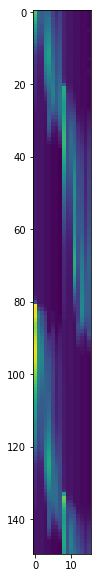

In [104]:
# This is an example of what we are feeding to the convolutional network, illustrated as an image
# but instead of the height of 240 pixels, I am showing just the first 150.

plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(a[1].reshape(image_height, 16)[:150, :])
plt.show()


In [196]:
model = Sequential()
model.add(Conv2D(24, (7, 7), padding='same', kernel_initializer='glorot_uniform',
                 input_shape=a.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

early_stopping = EarlyStopping(monitor='val_acc', patience=60, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./model/model_parkinsons_v0.h5", 
                             monitor='val_acc', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.summary()

In [170]:
# Use the fit_generator in conjunction with use_multiprocessing=True to get more performance out
# Do not use together with workers-parameter.

history = model.fit_generator(generate_arrays_from_file(train_files), 
                    validation_data=generate_arrays_from_file(test_files),
                    steps_per_epoch=training_set_steps_per_epoch, 
                    validation_steps=test_set_steps_per_epoch,
                    verbose=2,
                    epochs=100, 
                    shuffle=True,
                    use_multiprocessing=True,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/100
 - 15s - loss: 0.3778 - acc: 0.8973 - val_loss: 0.8560 - val_acc: 0.7158
Epoch 2/100
 - 15s - loss: 0.3585 - acc: 0.9054 - val_loss: 2.7445 - val_acc: 0.7148
Epoch 3/100
 - 15s - loss: 0.3393 - acc: 0.9111 - val_loss: 0.8257 - val_acc: 0.7310
Epoch 4/100
 - 15s - loss: 0.3271 - acc: 0.9173 - val_loss: 1.1503 - val_acc: 0.4042
Epoch 5/100
 - 15s - loss: 0.2876 - acc: 0.9269 - val_loss: 1.6179 - val_acc: 0.7148
Epoch 6/100
 - 15s - loss: 0.2832 - acc: 0.9287 - val_loss: 0.6538 - val_acc: 0.6772
Epoch 7/100
 - 15s - loss: 0.2616 - acc: 0.9340 - val_loss: 1.9580 - val_acc: 0.7148
Epoch 8/100
 - 15s - loss: 0.2774 - acc: 0.9326 - val_loss: 1.6605 - val_acc: 0.7148
Epoch 9/100
 - 15s - loss: 0.2739 - acc: 0.9333 - val_loss: 1.4165 - val_acc: 0.3975
Epoch 10/100
 - 15s - loss: 0.2687 - acc: 0.9357 - val_loss: 1.7560 - val_acc: 0.7148
Epoch 11/100
 - 15s - loss: 0.2532 - acc: 0.9378 - val_loss: 1.7740 - val_acc: 0.7148
Epoch 12/100
 - 15s - loss: 0.2558 - acc: 0.9394 - val_loss: 1.

Epoch 97/100
 - 15s - loss: 0.3097 - acc: 0.9485 - val_loss: 0.4815 - val_acc: 0.8167
Epoch 98/100
 - 15s - loss: 0.2712 - acc: 0.9526 - val_loss: 1.5584 - val_acc: 0.7541
Epoch 99/100
 - 15s - loss: 0.3269 - acc: 0.9486 - val_loss: 0.4027 - val_acc: 0.8475
Epoch 100/100
 - 15s - loss: 0.2488 - acc: 0.9541 - val_loss: 0.4131 - val_acc: 0.8473


<b>Ok, so once again we are overfitting a bit, but that was to be expected. We get accuracy of about 85% on the test set.</b>

In [193]:
parkmodel = load_model("./model/model_parkinsons_v0.h5")

In [117]:
n_park = 0
n_control = 0

for f in test_files:
    if (f.find("Co") > 0):
        n_control += 1
    else:
        n_park += 1

In [119]:
n_control, n_park

(17, 43)

In [199]:
# Majority voting results per file
# With the trained model, we get 8 incorrect classifications for the 60 test files.
# With the cases that we did not correctly classify, we will print out the distribution of votes.

LOAD_MODEL = False
correct = 0
incorrect = 0

true_y = []
predicted_y = []

if (LOAD_MODEL):
    parkmodel = load_model("./model/model_parkinsons_v0.h5")

for f in test_files:
    d_x, label = produceImagesFromFile(file=f, image_height=240)
    
    predictions = parkmodel.predict_classes(d_x)
    
    predict_distribution = pd.Series(predictions).value_counts()
    predictClass = predict_distribution.idxmax()
    
    true_y.append(label)
    predicted_y.append(predictClass)
    
    if (label == predictClass):
        prediction_text = "correct"
        correct += 1
    else:
        prediction_text = "incorrect (vote distribution: %s)" % (predict_distribution.values)
        incorrect += 1

    output = ("prediction was %s for %s") % (prediction_text, os.path.basename(f))
    print(output)

print(("Number of samples: %d, %d correct, %d incorrect.") % 
    (correct+incorrect, correct, incorrect))

prediction was correct for JuPt20_01.txt
prediction was correct for SiPt19_01.txt
prediction was correct for JuPt20_07.txt
prediction was correct for GaPt06_01.txt
prediction was correct for SiCo10_01.txt
prediction was correct for SiPt25_01.txt
prediction was correct for SiCo08_01.txt
prediction was correct for GaPt25_01.txt
prediction was correct for JuPt14_01.txt
prediction was correct for SiPt28_01.txt
prediction was correct for JuPt28_04.txt
prediction was correct for GaCo05_02.txt
prediction was correct for JuPt23_07.txt
prediction was correct for JuCo08_01.txt
prediction was correct for GaPt14_02.txt
prediction was correct for GaPt23_02.txt
prediction was incorrect (vote distribution: [44  3]) for JuPt01_06.txt
prediction was correct for GaCo09_01.txt
prediction was correct for SiPt33_01.txt
prediction was correct for JuPt26_06.txt
prediction was correct for JuPt06_01.txt
prediction was correct for SiPt24_01.txt
prediction was correct for JuPt25_01.txt
prediction was correct for

In [203]:
from sklearn.metrics import recall_score, f1_score, precision_score
recall = recall_score(true_y, predicted_y)
precision = precision_score(true_y, predicted_y)
f1 = f1_score(true_y, predicted_y)

print('Recall score: {0:0.2f}'.format(recall))
print('Precision score: {0:0.2f}'.format(precision))
print('F1-score: {0:0.2f}'.format(precision))

Recall score: 0.88
Precision score: 0.93
F1-score: 0.93
